## You're here! 
Welcome to your first competition in the [ITI's AI Pro training program](https://ai.iti.gov.eg/epita/ai-engineer/)! We hope you enjoy and learn as much as we did prepairing this competition.


## Introduction

In the competition, it's required to predict the `Severity` of a car crash given info about the crash, e.g., location.

This is the getting started notebook. Things are kept simple so that it's easier to understand the steps and modify it.

Feel free to `Fork` this notebook and share it with your modifications **OR** use it to create your submissions.

### Prerequisites
You should know how to use python and a little bit of Machine Learning. You can apply the techniques you learned in the training program and submit the new solutions! 

### Checklist
You can participate in this competition the way you perefer. However, I recommend following these steps if this is your first time joining a competition on Kaggle.

* Fork this notebook and run the cells in order.
* Submit this solution.
* Make changes to the data processing step as you see fit.
* Submit the new solutions.

*You can submit up to 5 submissions per day. You can select only one of the submission you make to be considered in the final ranking.*


Don't hesitate to leave a comment or contact me if you have any question!

## Import the libraries

We'll use `pandas` to load and manipulate the data. Other libraries will be imported in the relevant sections.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as Xet
import os

## Exploratory Data Analysis
In this step, one should load the data and analyze it. However, I'll load the data and do minimal analysis. You are encouraged to do thorough analysis!

Let's load the data using `pandas` and have a look at the generated `DataFrame`.

In [2]:
dataset_path = '/kaggle/input/car-crashes-severity-prediction/'

df = pd.read_csv(os.path.join(dataset_path, 'train.csv'))

print("The shape of the dataset is {}.\n\n".format(df.shape))

df.head()

The shape of the dataset is (6407, 16).




,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Stop,Amenity,Side,Severity,timestamp
0,0,37.762150,-122.405660,False,0.044,False,False,False,False,False,False,False,True,R,2,2016-03-25 15:13:02
1,1,37.719157,-122.448254,False,0.000,False,False,False,False,False,False,False,False,R,2,2020-05-05 19:23:00
2,2,37.808498,-122.366852,False,0.000,False,False,False,False,False,False,True,False,R,3,2016-09-16 19:57:16
3,3,37.785930,-122.391080,False,0.009,False,False,True,False,False,False,False,False,R,1,2020-03-29 19:48:43
4,4,37.719141,-122.448457,False,0.000,False,False,False,False,False,False,False,False,R,2,2019-10-09 08:47:00


We've got 6407 examples in the dataset with 14 featues, 1 ID, and the `Severity` of the crash.

By looking at the features and a sample from the data, the features look of numerical and catogerical types. What about some descriptive statistics?

Checking Duplicated data

In [3]:
df.duplicated().value_counts()

False    6407
dtype: int64

Droping ID column

In [4]:
df.drop(columns='ID').describe()

,Lat,Lng,Distance(mi),Severity
count,6407.000000,6407.000000,6407.000000,6407.000000
mean,37.765653,-122.405990,0.135189,2.293429
std,0.032555,0.028275,0.396360,0.521225
min,37.609619,-122.510440,0.000000,1.000000
25%,37.737096,-122.412210,0.000000,2.000000
50%,37.768238,-122.404835,0.000000,2.000000
75%,37.787813,-122.392477,0.041000,3.000000
max,37.825626,-122.349734,6.820000,4.000000


In [5]:
df.drop(columns='ID').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6407 entries, 0 to 6406
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lat           6407 non-null   float64
 1   Lng           6407 non-null   float64
 2   Bump          6407 non-null   bool   
 3   Distance(mi)  6407 non-null   float64
 4   Crossing      6407 non-null   bool   
 5   Give_Way      6407 non-null   bool   
 6   Junction      6407 non-null   bool   
 7   No_Exit       6407 non-null   bool   
 8   Railway       6407 non-null   bool   
 9   Roundabout    6407 non-null   bool   
 10  Stop          6407 non-null   bool   
 11  Amenity       6407 non-null   bool   
 12  Side          6407 non-null   object 
 13  Severity      6407 non-null   int64  
 14  timestamp     6407 non-null   object 
dtypes: bool(9), float64(3), int64(1), object(2)
memory usage: 356.8+ KB


The output shows desciptive statistics for the numerical features, `Lat`, `Lng`, `Distance(mi)`, and `Severity`. I'll use the numerical features to demonstrate how to train the model and make submissions. **However you shouldn't use the numerical features only to make the final submission if you want to make it to the top of the leaderboard.**

In [6]:
#importing xml file

cols = ["Date", "Holiday"]
rows = []
  
# Parsing the XML file
xmlparse = Xet.parse(os.path.join(dataset_path, 'holidays.xml'))
root = xmlparse.getroot()
for i in root:
    Date = i.find("date").text
    Holiday = i.find("description").text
  
    rows.append({"Date": Date,
                 "Holiday": Holiday})
  
df_holidays = pd.DataFrame(rows, columns=cols)


In [7]:
# splitting timestamp into years.months and days
df_holidays['Year']=pd.DatetimeIndex(df_holidays['Date']).year
df_holidays['Month']=pd.DatetimeIndex(df_holidays['Date']).month
df_holidays['Day']=pd.DatetimeIndex(df_holidays['Date']).day
df_holidays.head()

,Date,Holiday,Year,Month,Day
0,2012-01-02,New Year Day,2012,1,2
1,2012-01-16,Martin Luther King Jr. Day,2012,1,16
2,2012-02-20,Presidents Day (Washingtons Birthday),2012,2,20
3,2012-05-28,Memorial Day,2012,5,28
4,2012-07-04,Independence Day,2012,7,4


In [8]:
#reading weather csv and split dropping duplicates
df_weather=pd.read_csv(os.path.join(dataset_path, 'weather-sfcsv.csv'))

df_weather=df_weather.drop(columns=['Wind_Chill(F)','Precipitation(in)','Selected'])

df_weather.drop_duplicates(['Year','Month','Day','Hour'],keep="first", inplace=True)

df_weather['Visibility(mi)'].fillna((df_weather['Visibility(mi)'].mean()),inplace=True)

df_weather['Humidity(%)'].fillna((df_weather['Humidity(%)'].mean()),inplace=True)

df_weather['Temperature(F)'].fillna((df_weather['Temperature(F)'].mean()),inplace=True)

df_weather.head()

,Year,Day,Month,Hour,Weather_Condition,Temperature(F),Humidity(%),Wind_Speed(mph),Visibility(mi)
0,2020,27,7,18,Fair,64.0,70.0,20.0,10.0
1,2017,30,9,17,Partly Cloudy,71.1,57.0,9.2,10.0
2,2017,27,6,5,Overcast,57.9,87.0,15.0,9.0
3,2016,7,9,9,Clear,66.9,73.0,4.6,10.0
4,2019,19,10,2,Fair,52.0,89.0,0.0,9.0


## Data Prepration

In [9]:
def split_hour(hour):
    if hour>=0 and hour<=2:
        return 0
    elif hour>=3 and hour<=5:
        return 1
    elif hour>=6 and hour<=8:
        return 2
    elif hour>=9 and hour<=11:
        return 3
    elif hour>=12 and hour<=14:
        return 4
    elif hour>=15 and hour<=17:
        return 5
    elif hour>=18 and hour<=20:
        return 6
    elif hour>=21 and hour<=23:
        return 7

In [10]:
def date_time(df):
    
    # Splitting timestamp
    df['Year']=pd.DatetimeIndex(df['timestamp']).year
    df['Month']=pd.DatetimeIndex(df['timestamp']).month
    df['Day']=pd.DatetimeIndex(df['timestamp']).day
    df['Hour']=pd.DatetimeIndex(df['timestamp']).hour
    df['Weekday']=pd.DatetimeIndex(df['timestamp']).weekday
    df.drop(['timestamp'],axis=1,inplace=True)

In [11]:
def boolToNum(df):
    df=df.astype({'Bump':'int','Crossing':'int','Give_Way':'int','Junction':'int','No_Exit':'int','Railway':'int','Roundabout':'int','Stop':'int','Amenity':'int'})
    df["Side"]=df["Side"].replace({"R":"0","L":"1"})
    return df

In [12]:
def splitSegments(df):
    df['Splitting-Segments']=df['Hour'].apply(split_hour)
    df.head()

In [13]:
#Creating unquie weather Condition into categories
df_weather.loc[df_weather["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Thunderstorm"
df_weather.loc[df_weather["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Snow"
df_weather.loc[df_weather["Weather_Condition"].str.contains("Rain|Drizzle|Shower", na=False), "Weather_Condition"] = "Rain"
df_weather.loc[df_weather["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Windy"
df_weather.loc[df_weather["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Hail"
df_weather.loc[df_weather["Weather_Condition"].str.contains("Fair", na=False), "Weather_Condition"] = "Clear"
df_weather.loc[df_weather["Weather_Condition"].str.contains("Cloud|Overcast", na=False), "Weather_Condition"] = "Cloudy"
df_weather.loc[df_weather["Weather_Condition"].str.contains("Mist|Haze|Fog", na=False), "Weather_Condition"] = "Fog"
df_weather.loc[df_weather["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Sand"
df_weather.loc[df_weather["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Smoke"
df_weather.loc[df_weather["Weather_Condition"].str.contains("N/A Precipitation", na=False), "Weather_Condition"] = np.nan
unique_weather = df_weather["Weather_Condition"].unique()
df_weather['Weather_Condition']=pd.get_dummies(df_weather['Weather_Condition'])


In [14]:
def data_cleaning(df,df_weather,df_holidays):
    
    date_time(df)
    
    #Chaning boolen to numerical 
    df=boolToNum(df)
    
    #splitting hours into 8 segments
    splitSegments(df)
    
    
    df=pd.merge(df, df_weather,  how='left', left_on=['Year','Month','Day','Hour'], right_on = ['Year','Month','Day','Hour'])
    df=pd.merge(df, df_holidays,  how='left', left_on=['Year','Month','Day',], right_on = ['Year','Month','Day']).drop(columns=['Date'],axis=1)
    df['Holiday']=df["Holiday"].notnull().astype('int')
    
    return df

In [15]:
df.head()

,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Stop,Amenity,Side,Severity,timestamp
0,0,37.762150,-122.405660,False,0.044,False,False,False,False,False,False,False,True,R,2,2016-03-25 15:13:02
1,1,37.719157,-122.448254,False,0.000,False,False,False,False,False,False,False,False,R,2,2020-05-05 19:23:00
2,2,37.808498,-122.366852,False,0.000,False,False,False,False,False,False,True,False,R,3,2016-09-16 19:57:16
3,3,37.785930,-122.391080,False,0.009,False,False,True,False,False,False,False,False,R,1,2020-03-29 19:48:43
4,4,37.719141,-122.448457,False,0.000,False,False,False,False,False,False,False,False,R,2,2019-10-09 08:47:00


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6407 entries, 0 to 6406
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            6407 non-null   int64  
 1   Lat           6407 non-null   float64
 2   Lng           6407 non-null   float64
 3   Bump          6407 non-null   bool   
 4   Distance(mi)  6407 non-null   float64
 5   Crossing      6407 non-null   bool   
 6   Give_Way      6407 non-null   bool   
 7   Junction      6407 non-null   bool   
 8   No_Exit       6407 non-null   bool   
 9   Railway       6407 non-null   bool   
 10  Roundabout    6407 non-null   bool   
 11  Stop          6407 non-null   bool   
 12  Amenity       6407 non-null   bool   
 13  Side          6407 non-null   object 
 14  Severity      6407 non-null   int64  
 15  timestamp     6407 non-null   object 
dtypes: bool(9), float64(3), int64(2), object(2)
memory usage: 406.8+ KB


In [17]:
df= data_cleaning(df,df_weather,df_holidays)

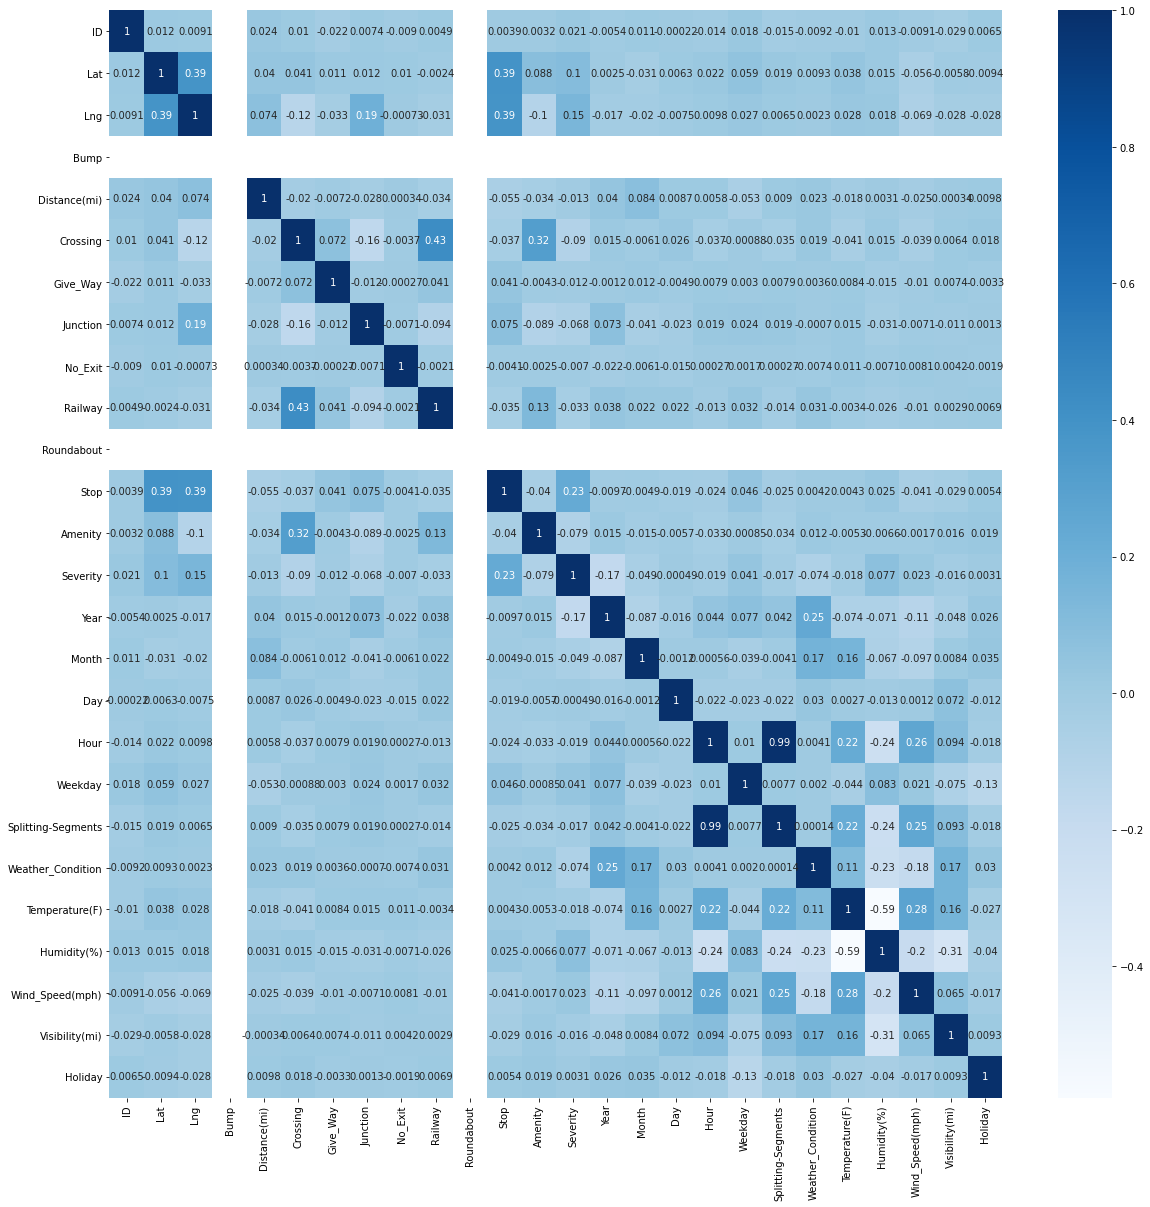

In [18]:

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), annot = True,cmap='Blues');
plt.show()

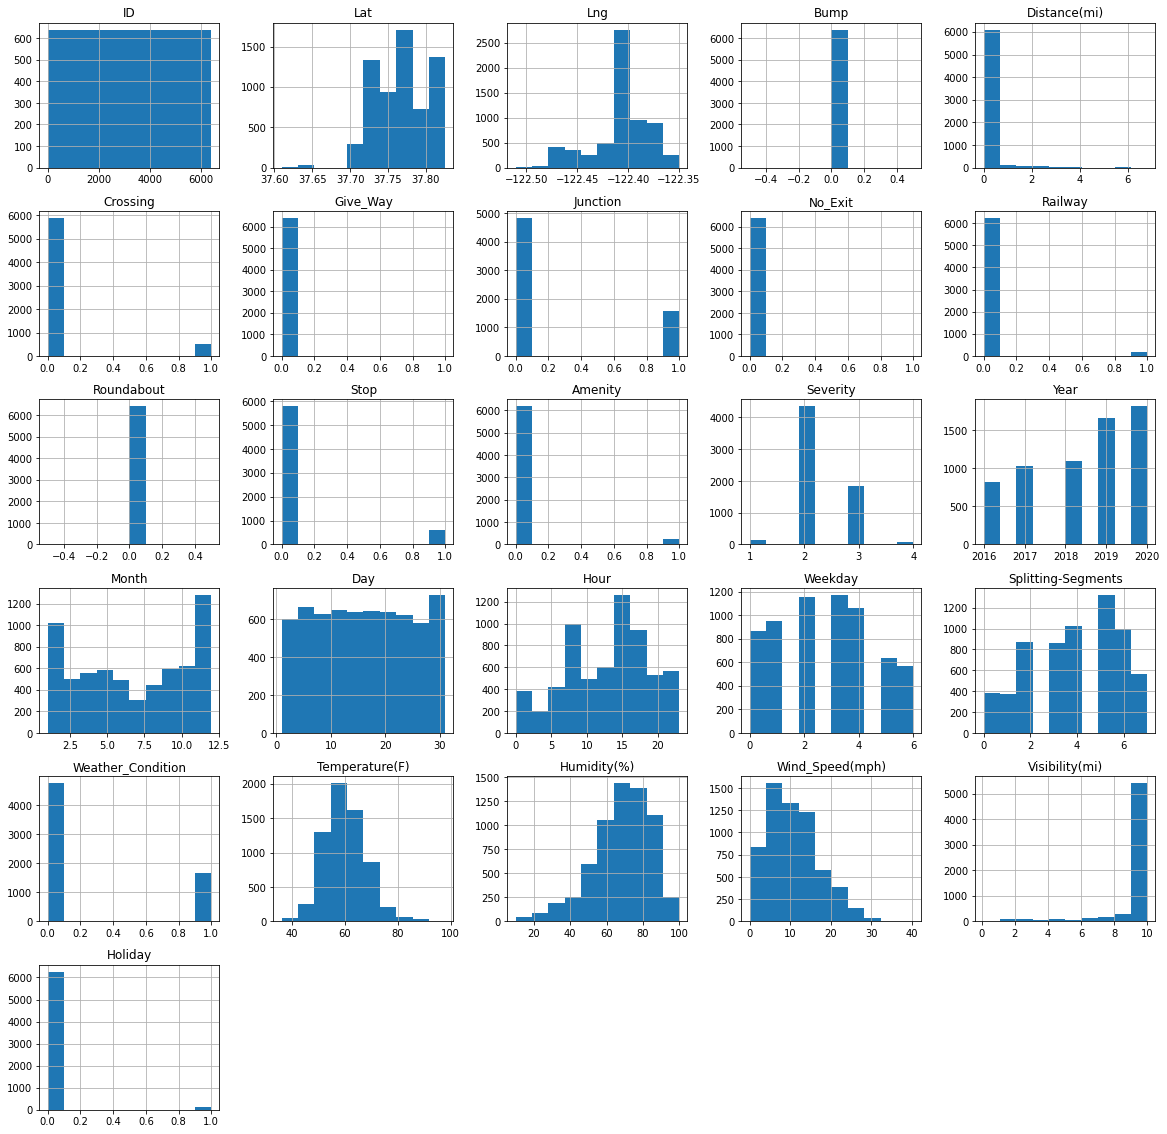

In [19]:
df.hist(figsize=(20,20))
plt.show()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6407 entries, 0 to 6406
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  6407 non-null   int64  
 1   Lat                 6407 non-null   float64
 2   Lng                 6407 non-null   float64
 3   Bump                6407 non-null   int64  
 4   Distance(mi)        6407 non-null   float64
 5   Crossing            6407 non-null   int64  
 6   Give_Way            6407 non-null   int64  
 7   Junction            6407 non-null   int64  
 8   No_Exit             6407 non-null   int64  
 9   Railway             6407 non-null   int64  
 10  Roundabout          6407 non-null   int64  
 11  Stop                6407 non-null   int64  
 12  Amenity             6407 non-null   int64  
 13  Side                6407 non-null   object 
 14  Severity            6407 non-null   int64  
 15  Year                6407 non-null   int64  
 16  Month 

## Feature Importance

Text(0.5, 0, 'Random Forest Feature Importance')

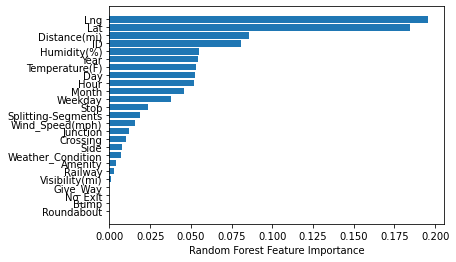

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)


train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

X_train = train_df.drop(['Severity','Wind_Speed(mph)'],axis=1)
y_train = train_df['Severity']
rf.fit(X_train, y_train)
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df.drop('Severity',axis=1).columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [22]:
Features=['Lng','Lat','Distance(mi)','Humidity(%)','Year','Day','Hour','Month','Weather_Condition']

## Data Splitting

Now it's time to split the dataset for the training step. Typically the dataset is split into 3 subsets, namely, the training, validation and test sets. In our case, the test set is already predefined. So we'll split the "training" set into training and validation sets with 0.8:0.2 ratio. 

*Note: a good way to generate reproducible results is to set the seed to the algorithms that depends on randomization. This is done with the argument `random_state` in the following command* 

In [23]:
# RobustScaler is better in handling Outliers :
df.head()

,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,...,Day,Hour,Weekday,Splitting-Segments,Weather_Condition,Temperature(F),Humidity(%),Wind_Speed(mph),Visibility(mi),Holiday
0,0,37.762150,-122.405660,0,0.044,0,0,0,0,0,...,25,15,4,5,0,64.0,58.0,23.0,10.0,0
1,1,37.719157,-122.448254,0,0.000,0,0,0,0,0,...,5,19,1,6,0,57.0,83.0,22.0,10.0,0
2,2,37.808498,-122.366852,0,0.000,0,0,0,0,0,...,16,19,4,6,1,62.1,80.0,9.2,10.0,0
3,3,37.785930,-122.391080,0,0.009,0,0,1,0,0,...,29,19,6,6,1,58.0,70.0,10.0,10.0,0
4,4,37.719141,-122.448457,0,0.000,0,0,0,0,0,...,9,8,2,2,1,58.0,65.0,3.0,10.0,0


In [24]:

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42) # Try adding `stratify` here

X_train = train_df[Features]

y_train = train_df['Severity']

X_val = val_df[Features]
y_val = val_df['Severity']

As pointed out eariler, I'll use the numerical features to train the classifier. **However, you shouldn't use the numerical features only to make the final submission if you want to make it to the top of the leaderboard.** 

## Model Training

Let's train a model with the data! We'll train a Random Forest Classifier to demonstrate the process of making submissions. 

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the classifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)

# Train the classifier
classifier = classifier.fit(X_train, y_train)


Now let's test our classifier on the validation dataset and see the accuracy.

In [26]:
print("The accuracy of the classifier on the validation set is ", (classifier.score(X_val, y_val)))

The accuracy of the classifier on the validation set is  0.7480499219968799


# 
Well. That's a good start, right? A classifier that predicts all examples' `Severity` as 2 will get around 0.63. You should get better score as you add more features and do better data preprocessing.

## Submission File Generation

We have built a model and we'd like to submit our predictions on the test set! In order to do that, we'll load the test set, predict the class and save the submission file. 

First, we'll load the data.

In [27]:
test_df = pd.read_csv(os.path.join(dataset_path, 'test.csv'))
test_df.head()

,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Stop,Amenity,Side,timestamp
0,6407,37.786060,-122.390900,False,0.039,False,False,True,False,False,False,False,False,R,2016-04-04 19:20:31
1,6408,37.769609,-122.415057,False,0.202,False,False,False,False,False,False,False,False,R,2020-10-28 11:51:00
2,6409,37.807495,-122.476021,False,0.000,False,False,False,False,False,False,False,False,R,2019-09-09 07:36:45
3,6410,37.761818,-122.405869,False,0.000,False,False,True,False,False,False,False,False,R,2019-08-06 15:46:25
4,6411,37.732350,-122.414100,False,0.670,False,False,False,False,False,False,False,False,R,2018-10-17 09:54:58


Note that the test set has the same features and doesn't have the `Severity` column.
At this stage one must **NOT** forget to apply the same processing done on the training set on the features of the test set.

Now we'll add `Severity` column to the test `DataFrame` and add the values of the predicted class to it.

**I'll select the numerical features here as I did in the training set. DO NOT forget to change this step as you change the preprocessing of the training data.**

In [28]:
test_df=data_cleaning(test_df,df_weather,df_holidays)

In [29]:
X_test = test_df.drop(columns=['ID'])

# You should update/remove the next line once you change the features used for training
X_test = X_test[Features]

y_test_predicted = classifier.predict(X_test)

test_df['Severity'] = y_test_predicted

test_df.head()

,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,...,Hour,Weekday,Splitting-Segments,Weather_Condition,Temperature(F),Humidity(%),Wind_Speed(mph),Visibility(mi),Holiday,Severity
0,6407,37.786060,-122.390900,0,0.039,0,0,1,0,0,...,19,0,6,0,63.0,60.0,10.4,10.0,0,2
1,6408,37.769609,-122.415057,0,0.202,0,0,0,0,0,...,11,2,3,1,65.0,56.0,5.0,9.0,0,2
2,6409,37.807495,-122.476021,0,0.000,0,0,0,0,0,...,7,0,2,0,58.0,90.0,18.0,10.0,0,2
3,6410,37.761818,-122.405869,0,0.000,0,0,1,0,0,...,15,1,5,1,72.0,59.0,17.0,10.0,0,2
4,6411,37.732350,-122.414100,0,0.670,0,0,0,0,0,...,9,2,3,0,57.0,77.0,5.8,10.0,0,2


Now we're ready to generate the submission file. The submission file needs the columns `ID` and `Severity` only.

In [30]:
test_df[['ID', 'Severity']].to_csv('/kaggle/working/submission.csv', index=False)

The remaining steps is to submit the generated file and are as follows. 

1. Press `Save Version` on the upper right corner of this notebook.
2. Write a `Version Name` of your choice and choose `Save & Run All (Commit)` then click `Save`.
3. Wait for the saved notebook to finish running the go to the saved notebook.
4. Scroll down until you see the output files then select the `submission.csv` file and click `Submit`.

Now your submission will be evaluated and your score will be updated on the leaderboard! CONGRATULATIONS!!

## Conclusion

In this notebook, we have demonstrated the essential steps that one should do in order to get "slightly" familiar with the data and the submission process. We chose not to go into details in each step to keep the welcoming notebook simple and make a room for improvement.

You're encourged to `Fork` the notebook, edit it, add your insights and use it to create your submission.